# Lecture 11 – Classification of DER Types from Load Features

**Overview**  
In this notebook, we transition from our previous unsupervised clustering work (Lecture 10) to **supervised classification** of distributed energy resource (DER) types using household load‐feature data. You will:

- Merge engineered features with DER labels  
- Partition data into **train**, **validation**, and **test** sets  
- Train and evaluate three models: Logistic Regression, Random Forest, and LightGBM  
- Learn to interpret **classification metrics** (accuracy, precision, recall, F1, support)  
- Extract **feature importances** and **decision rules** for interpretability  

**Learning Objectives**

By the end of this notebook, students will be able to:

1. **Prepare** labeled datasets and understand the role of train/validation/test splits.  
2. **Explain** and implement stratified sampling to preserve class distributions.  
3. **Train** baseline (LogReg) and advanced tree-based (RF, LightGBM) classifiers.  
4. **Compute** and **interpret** macro-F1 scores, confusion matrices, and classification reports.  
5. **Visualize** and **extract** feature importances and decision rules.  
6. **Reflect** on model trade-offs in performance vs. interpretability.

---


## 1. Importing Required Libraries

Before we begin analyzing and modeling data, we need to import the necessary libraries. These tools cover everything from data manipulation and visualization to machine learning and evaluation.

* **`pandas`** and **`numpy`**: Essential libraries for data manipulation and numerical operations.
* **`matplotlib.pyplot`**: Used for creating static visualizations of data.
* **`scikit-learn`**: Provides utilities for preprocessing data, building models (e.g., Random Forests, Logistic Regression), splitting datasets, and evaluating model performance.
* **`lightgbm`**: A highly efficient gradient boosting framework that is particularly well-suited for structured data and large datasets.
* **Additional modules**: We also utilize system tools (`os`, `pickle`, `urllib`) for file handling and downloading, and `scipy.stats.kurtosis` for statistical analysis.

If `lightgbm` is not already installed, you can install it using the following command:

```bash
pip install lightgbm
```

In [1]:
# ─── Standard Library for File I/O and Downloading ────────────────────────────────
import os                                 # Interact with the operating system (paths, directories)
import pickle                             # Serialize and deserialize Python objects
import urllib.request                     # Download data from URLs

# ─── Data Handling and Numerical Computation ─────────────────────────────────────
import numpy as np                        # Array operations and numerical computing
import pandas as pd                       # Data structures (DataFrame) and data analysis

# ─── Data Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt           # Static, interactive, and animated plotting

# ─── Statistical Functions ──────────────────────────────────────────────────────
from scipy.stats import kurtosis          # Tailedness measure of a distribution

# ─── Data Preprocessing and Splitting ────────────────────────────────────────────
from sklearn.model_selection import train_test_split  # Split data into training/testing sets
from sklearn.preprocessing import StandardScaler     # Standardize features (zero mean, unit variance)

# ─── Machine Learning Models ─────────────────────────────────────────────────────
import lightgbm as lgb                   # Gradient boosting framework for decision trees
from sklearn.ensemble import RandomForestClassifier  # Ensemble of decision trees for classification
from sklearn.linear_model import LogisticRegression  # Linear classifier using logistic function
from sklearn.manifold import TSNE                    # Dimensionality reduction for visualization

# ─── Model Evaluation and Interpretation ─────────────────────────────────────────
from sklearn.metrics import (
    accuracy_score,                   # Fraction of correctly predicted instances
    classification_report,            # Precision, recall, f1-score for each class
    f1_score                          # Harmonic mean of precision and recall
)
from sklearn.inspection import permutation_importance  # Feature importance via permutation tests

## 2. Load and Explore Data

Load the CSV of 15-minute consumption/injection data, inspect its shape, and plot two sample meters to get a feel for raw load profiles.

This dataset is part of the corpus of quarter hourly data from 1,300 residential buildings in Flanders (Belgium) made openly available for the year 2022 by Fluvius, the Flemish DSO. We will be using parts of this dataset during our lecture 10 through 12. 

**This cell creates an `inputs/` folder (if it doesn't already exist) and downloads two data files from the GitHub repository into that folder:**

1. `sample_smart_meter_data.parquet` — the smart meter readings dataset.
2. `sample_smart_meter_labels.csv` — the corresponding labels indicating the category of each meter.

> **Note on File Formats:**

* The **Parquet** file (`.parquet`) is used to store the meter data. Parquet is a columnar storage format optimized for performance and efficiency with large datasets. It supports compression, faster querying of specific columns, and schema evolution. You can treat it like a regular Pandas DataFrame once loaded. For more details, see the [Pandas Parquet documentation](https://pandas.pydata.org/docs/user_guide/io.html#parquet).
* The **CSV** file (`.csv`) contains category labels for each meter and is small enough that CSV remains a suitable format for it. It's straightforward to load using `pandas.read_csv()`.

If you're using **Google Colab**, the required backend (`pyarrow`) for reading Parquet files is pre-installed.

If you're working **locally**, ensure that `pyarrow` is installed by running:

```bash
pip install pyarrow
```

This setup allows you to efficiently load both the smart meter data and the associated labels for further analysis.


In [2]:
# Create the 'inputs' folder if it doesn't exist
os.makedirs('inputs', exist_ok=True)

# Define the files to download
files = [
    {
        "url": "https://raw.githubusercontent.com/nick-harder/AIES/main/lecture10/data/sample_smart_meter_data.parquet",
        "local_path": "inputs/sample_smart_meter_data.parquet"
    },
    {
        "url": "https://raw.githubusercontent.com/nick-harder/AIES/main/lecture10/data/sample_smart_meter_labels.csv",
        "local_path": "inputs/sample_smart_meter_labels.csv"
    }
]

# Download each file if not already present
for file in files:
    if not os.path.exists(file["local_path"]):
        print(f"Downloading data from {file['url']} ...")
        urllib.request.urlretrieve(file["url"], file["local_path"])
        print("Download complete.")
    else:
        print(f"File {file['local_path']} already exists, skipping download.")

File inputs/sample_smart_meter_data.parquet already exists, skipping download.
File inputs/sample_smart_meter_labels.csv already exists, skipping download.


Dataset shape: (14016000, 4)
   Meter_ID           Timestamp  Consumption_kWh  Injection_kWh
0       608 2022-01-01 00:00:00            0.133            0.0
1       608 2022-01-01 00:15:00            0.457            0.0
2       608 2022-01-01 00:30:00            0.115            0.0
3       608 2022-01-01 00:45:00            0.124            0.0
4       608 2022-01-01 01:00:00            0.471            0.0
Labels shape: (400, 2)
   Meter_ID Category_Label
0       608        EV_Only
1       327        EV_Only
2       967        PV_Only
3       502        PV_Only
4       520       Baseline


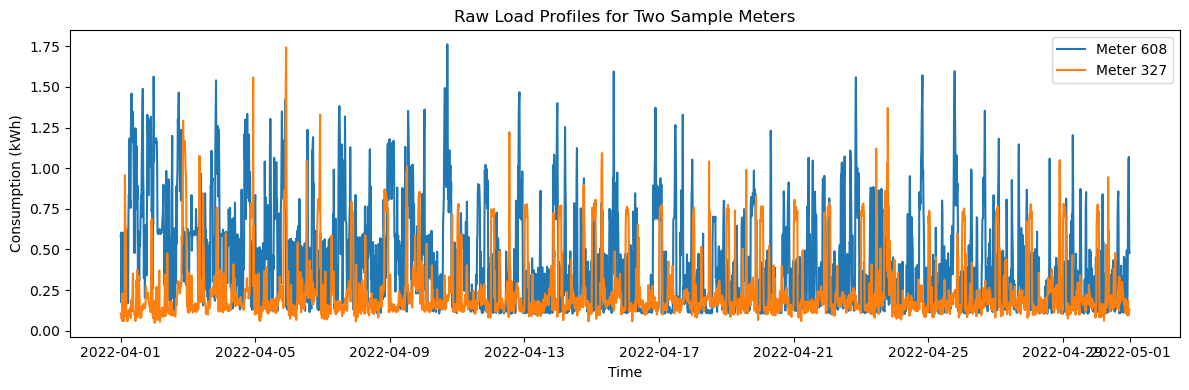

In [3]:
# 1.1 Load
df = pd.read_parquet(files[0]["local_path"]).reset_index()
true_labels = pd.read_csv(files[1]["local_path"])

# parse timestamps
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# 1.2 Overview
print("Dataset shape:", df.shape)
print(df.head())

print("Labels shape:", true_labels.shape)
print(true_labels.head())

# 1.3 Plot two sample meters
sample_ids = df["Meter_ID"].unique()[:2]
plt.figure(figsize=(12,4))
for meter in sample_ids:
    series = df[df["Meter_ID"]==meter].set_index("Timestamp")["Consumption_kWh"]
    # select only April 2023 data
    series = series[series.index.month == 4]
    plt.plot(series.index, series.values, label=f"Meter {meter}")
plt.legend()
plt.title("Raw Load Profiles for Two Sample Meters")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.tight_layout()
plt.show()

Unique labels: ['EV_Only' 'PV_Only' 'Baseline']


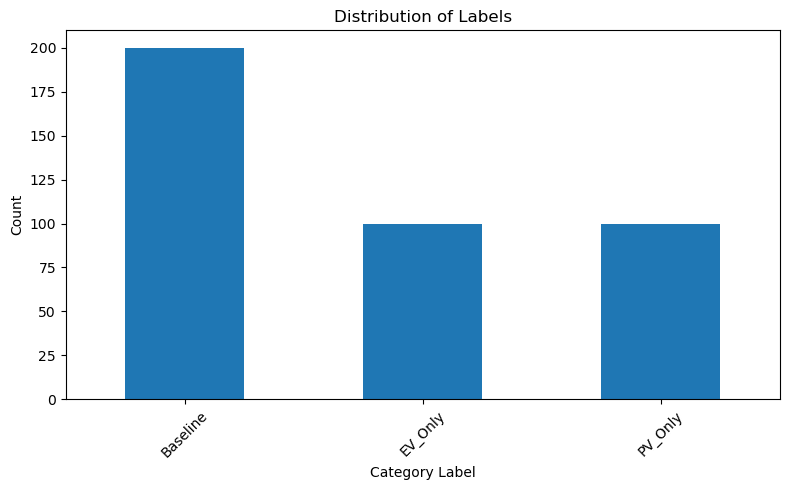

In [4]:
# Overview of the labels
print("Unique labels:", true_labels["Category_Label"].unique())

# Plot the distribution of labels
label_counts = true_labels["Category_Label"].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar')
plt.title("Distribution of Labels")
plt.xlabel("Category Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We also fix the random seed for reproducibility.

In [5]:
random_seed = 42

## 3. Feature Engineering

### 3.1 Domain-Agnostic Feature Extraction

We compute basic statistical features over each meter’s full time series and link them to physical insights:

- **Mean**: average consumption (baseline usage level)  
- **Standard deviation**: variability (load volatility)  
- **Skewness**: asymmetry (peak vs. off-peak behavior)  
- **Kurtosis**: peakedness (extreme events)  
- **Autocorrelation** at lag 1 and lag 24: temporal persistence (daily repeatability) 

In [6]:
def compute_mean(x):
    return x.mean()

def compute_std(x):
    return x.std()

def compute_skewness(x):
    return x.skew()

def compute_kurtosis(x):
    return float(kurtosis(x, fisher=True, nan_policy='omit'))

def compute_autocorr(x, lag):
    return float(x.autocorr(lag=lag))

def impute_missing(x):
    return x.ffill().bfill()


### 3.2. Domain-Informed Feature Extraction

These metrics capture patterns linked to DER presence (PV panels, EV charging):

- **Midday Dip**: drop around 12–14 h (PV generation reduces net consumption)  
- **Evening Ramp**: increase 18–21 h vs. 15–18 h (EV charging starts)  
- **Night/Day Ratio**: avg. load 00–06 h ÷ 06–18 h (overnight appliances)  
- **Weekend Load Factor**: avg. weekend ÷ weekday (occupancy patterns)  
- **Peak-to-Average Ratio**: peak demand ÷ mean (device spikes)  
- **Longest Period Above Mean**: continuous high-load streaks (e.g. heating)  
- **Longest Period of Successive Increase**: sustained rises (e.g. EV charging session)  

In [7]:
def compute_midday_dip(x):
    """
    Measures how much the consumption drops during midday hours (12:00–14:00)
    relative to the overall average.

    A pronounced dip could suggest solar PV generation reducing net load.
    """
    midday = x.between_time("12:00", "14:00").mean()
    return midday - x.mean()


def compute_evening_ramp(x):
    """
    Measures the increase in consumption from afternoon (15:00–18:00)
    to evening hours (18:00–21:00).

    A steep evening ramp may indicate the start of EV charging or cooking activity.
    """
    eve = x.between_time("18:00", "21:00").mean()
    aft = x.between_time("15:00", "18:00").mean()
    return eve - aft


def compute_night_day_ratio(x):
    """
    Computes the ratio of average night-time load (00:00–06:00)
    to average day-time load (06:00–18:00).

    This feature helps detect households with high overnight usage (e.g., EV charging).
    """
    night = x.between_time("00:00", "06:00").mean()
    day = x.between_time("06:00", "18:00").mean()
    return night / day


def compute_weekend_load_factor(x):
    """
    Calculates the ratio of weekend average load to weekday average load.

    Useful to detect occupancy patterns—e.g., higher weekend usage could indicate
    a home-based lifestyle or weekend charging.
    """
    wknd = x[x.index.dayofweek >= 5].mean()  # Saturday=5, Sunday=6
    wkday = x[x.index.dayofweek < 5].mean()  # Monday–Friday
    return wknd / wkday


def compute_peak_to_avg(x):
    """
    Ratio of peak load to average load across the entire time series.

    High values indicate "spikiness"—typically associated with event-driven loads like EV charging.
    """
    return x.max() / x.mean()


def compute_longest_above_mean(x):
    """
    Computes the longest consecutive time period during which consumption remains
    above the mean level.

    Long high-usage periods may indicate appliances with sustained load, such as HVAC or EVs.
    """
    threshold = x.mean()
    mask = x > threshold

    # If no values exceed the mean, return 0
    if not mask.any():
        return 0

    # Identify contiguous runs above the threshold
    runs = (mask != mask.shift()).cumsum()
    lengths = mask.groupby(runs).sum()
    return int(lengths.max())


def compute_longest_increase_streak(x):
    """
    Finds the longest sequence of strictly increasing consumption values
    in the time series.

    Can indicate gradual ramp-up behavior, such as slow EV charging or heat pump cycles.
    """
    delta = x.diff()
    mask = delta > 0

    if not mask.any():
        return 0

    runs = (mask != mask.shift()).cumsum()
    lengths = mask.groupby(runs).sum()
    return int(lengths.max())


### 3.3 Build Feature Matrix

Apply both sets of functions to each meter to assemble a feature DataFrame.

In [8]:
# Refactored: modular feature extraction
def extract_features(df, meter_id):
    series = df[df["Meter_ID"]==meter_id].set_index("Timestamp")["Consumption_kWh"]
    series = impute_missing(series)
    return {
        "Meter_ID": meter_id,
        "mean": compute_mean(series),
        "std": compute_std(series),
        "skew": compute_skewness(series),
        "kurtosis": compute_kurtosis(series),
        "autocorr_lag1": compute_autocorr(series,1),
        "autocorr_lag24": compute_autocorr(series,24),
        "midday_dip": compute_midday_dip(series),
        "evening_ramp": compute_evening_ramp(series),
        "night_day_ratio": compute_night_day_ratio(series),
        "weekend_load_factor": compute_weekend_load_factor(series),
        "peak_to_avg": compute_peak_to_avg(series),
        "longest_above_mean": compute_longest_above_mean(series),
        "longest_increase_streak": compute_longest_increase_streak(series),
    }

meters = df["Meter_ID"].unique() # Get unique meter IDs
feature_list = [extract_features(df, m) for m in meters] # Extract features for each meter

feature_df = pd.DataFrame(feature_list).set_index("Meter_ID") # Convert to DataFrame

print("Feature DataFrame shape:", feature_df.shape) # Display shape of feature DataFrame
feature_df.head()

Feature DataFrame shape: (400, 13)


,mean,std,skew,kurtosis,autocorr_lag1,autocorr_lag24,midday_dip,evening_ramp,night_day_ratio,weekend_load_factor,peak_to_avg,longest_above_mean,longest_increase_streak
Meter_ID,,,,,,,,,,,,,
608,0.516297,0.309316,1.443264,2.485672,0.737918,0.111948,-0.034059,0.003407,0.905779,0.988416,5.008749,117,8
327,0.218332,0.215655,2.511988,7.334723,0.810461,0.047719,-0.053909,0.035358,0.984055,0.969622,8.885541,665,9
967,0.129985,0.195175,2.776186,12.647182,0.787215,0.092139,-0.086156,0.065746,1.708974,0.996225,18.502077,76,12
502,0.073290,0.130620,4.145268,23.740559,0.704586,0.036122,-0.025973,-0.061971,0.952042,0.984458,24.095913,54,11
520,0.023823,0.044369,6.445891,50.531715,0.478176,-0.001294,-0.001080,-0.015082,0.938279,1.192957,27.326075,46,7


### 3.4 Feature Standardization

Normalize each feature to zero mean and unit variance for fair clustering. This ensures all features contribute equally to distance calculations. This is important for clustering algorithms like K-Means that are sensitive to feature scales.

> Info: If the data is not standardized, features with larger ranges can disproportionately influence the clustering results, leading to biased clusters. Imagine if one feature ranged from 0 to 1000 while another ranged from 0 to 1; the first feature would dominate the distance calculations, skewing the clusters. Below you can see an example plot of such two features before and after standardization and the resulting clusters.

In the following code cell, we standardize the feature matrix using `sklearn.preprocessing.StandardScaler`. This will ensure that each feature has a mean of 0 and a standard deviation of 1, making them comparable in the clustering process.

In [9]:
scaler = StandardScaler() # Initialize StandardScaler
scaled_arr = scaler.fit_transform(feature_df) # Fit and transform the feature DataFrame
scaled_df = pd.DataFrame(scaled_arr, index=feature_df.index, columns=feature_df.columns) # Create a new DataFrame with scaled values

scaled_df.head()

,mean,std,skew,kurtosis,autocorr_lag1,autocorr_lag24,midday_dip,evening_ramp,night_day_ratio,weekend_load_factor,peak_to_avg,longest_above_mean,longest_increase_streak
Meter_ID,,,,,,,,,,,,,
608,4.624299,1.225540,-1.407338,-0.589629,0.142687,0.439902,-0.463598,-0.104918,0.222558,-0.590707,-1.536611,-0.008041,-0.612633
327,1.156863,0.446088,-0.781374,-0.449004,0.694161,-0.134441,-1.000414,0.471326,0.378848,-0.675690,-1.053543,1.493377,-0.029173
967,0.128764,0.275652,-0.626630,-0.294940,0.517445,0.262774,-1.872511,1.019371,1.826246,-0.555400,0.144727,-0.120374,1.721207
502,-0.531000,-0.261579,0.175257,0.026774,-0.110699,-0.238148,-0.244921,-1.284042,0.314928,-0.608605,0.841747,-0.180650,1.137747
520,-1.106652,-0.979360,1.522759,0.803731,-1.831863,-0.572726,0.428300,-0.438378,0.287448,0.334170,1.244241,-0.202568,-1.196093


### 3.5 t-SNE Visualization

Project the high-dimensional feature space into 2D to explore natural groupings. For this, we use t-SNE with a perplexity of 30 and 1000 iterations. This will help us visualize the structure of the data and identify potential clusters. To read more about t-SNE, you can refer to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or here in a [medium article](https://medium.com/data-science/t-sne-clearly-explained-d84c537f53a).

This doesn't give us clusters directly, but it helps us see how the data points are distributed in a lower-dimensional space. And maybe you can already spot some clusters visually?


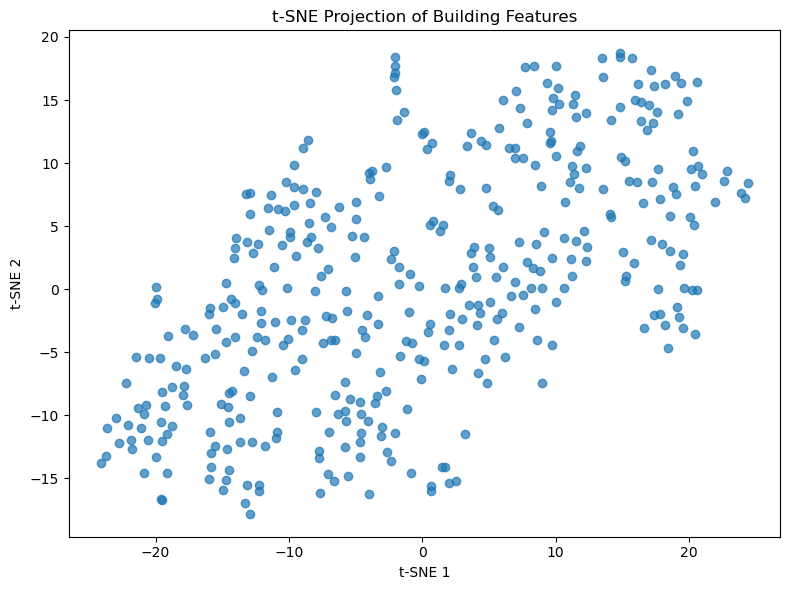

In [10]:
tsne = TSNE(n_components=2, random_state=random_seed)
coords = tsne.fit_transform(scaled_df)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], alpha=0.7)
plt.title("t-SNE Projection of Building Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

## 4. Splitting the Dataset

Before training any models, we must partition our data into three sets:

* **Training set**: for fitting model parameters
* **Validation set**: for hyperparameter tuning and early stopping
* **Test set**: for *final* evaluation

### 4.1. Stratified Sampling Explained

**Stratification** ensures each split preserves the same proportion of DER classes as the full dataset. In scikit-learn, passing `stratify=y` to `train_test_split` automatically does this.

> Note: *Conceptually*, stratification groups by label then samples proportionally. This avoids, for example, a validation set with no EV examples if EV is rare.

In [11]:
# 4.1 Merge features with labels
labeled_df = feature_df.join(
    true_labels.set_index("Meter_ID")["Category_Label"]
)
X_all = scaled_df.loc[labeled_df.index]
y_all = labeled_df["Category_Label"]

# 4.2 First split: train+val vs. test (70/30), stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.3,
    stratify=y_all,
    random_state=random_seed
)

# 4.3 Second split: validation set from the test set (50/50), stratified
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test,
    test_size=0.5,
    stratify=y_test,
    random_state=random_seed
)

# 4.4 Check distributions
print("Full set:", y_all.value_counts(normalize=True).round(3).to_dict())
print("Train set:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Val set:", y_val.value_counts(normalize=True).round(3).to_dict())
print("Test set:", y_test.value_counts(normalize=True).round(3).to_dict())

Full set: {'Baseline': 0.5, 'EV_Only': 0.25, 'PV_Only': 0.25}
Train set: {'Baseline': 0.5, 'PV_Only': 0.25, 'EV_Only': 0.25}
Val set: {'Baseline': 0.5, 'PV_Only': 0.25, 'EV_Only': 0.25}
Test set: {'Baseline': 0.5, 'EV_Only': 0.25, 'PV_Only': 0.25}


## 5. Baseline Classifier – Logistic Regression

We start with a **Logistic Regression** model as a simple benchmark.
This model is interpretable and provides a baseline for comparison with more complex models.

### 5.1  Train Logistic Regression Model
We use the `LogisticRegression` class from `sklearn.linear_model`, setting `max_iter=1000` to ensure convergence. The model is trained on the training set, and we evaluate its performance on the validation set using accuracy, precision, recall, F1-score, and support.

In [12]:
# Instantiate the Logistic Regression model
logreg_model = LogisticRegression(
    random_state=random_seed,
    max_iter=1000
)
# Fit the model
logreg_model.fit(X_train, y_train)

# Predict on validation
y_val_lr = logreg_model.predict(X_val)

# Save the model to a file in outputs folder
os.makedirs('outputs', exist_ok=True)
with open('outputs/logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg_model, f)

### 5.2 Understanding the Classification Report

This report provides a detailed breakdown of how well your clustering matches the ground truth. Here's how to interpret the key metrics shown in the report:

---

**1. Precision**
- **Definition**: Of all buildings predicted to belong to a class (e.g., EV_Only), how many truly belong to that class?
- **Formula**:  
  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$
- **High precision** means few false positives.

---

**2. Recall**
- **Definition**: Of all buildings that truly belong to a class, how many were correctly predicted?
- **Formula**:  
  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **High recall** means few false negatives.

---

**3. F1-Score**
- **Definition**: The harmonic mean of precision and recall. It balances both.
- **Formula**:  
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
- Useful when you want a single metric that considers both types of error.

---

**4. Support**
- **Definition**: The number of true instances for each class in the dataset.
- This gives context to the above scores—how many examples were available for each label.

---

**Tip:** Review both the confusion matrix and classification report to identify which classes are being misclassified and whether errors are systematic (e.g., always mislabeling EVs as Baseline).


In [13]:
# print training results
print("\nLogistic Regression Results:")

print("Training Results:")
y_train_pred = logreg_model.predict(X_train)
print("Training Accuracy:        ", accuracy_score(y_train, y_train_pred))
print("Training Macro-F1 Score:  ", f1_score(y_train, y_train_pred, average="macro"))

print("\nValidation Results:")
print("Validation Accuracy:       ", accuracy_score(y_val, y_val_lr))
print("Validation Macro-F1 Score: ", f1_score(y_val, y_val_lr, average="macro"))

# Confusion Matrix
conf = pd.crosstab(y_val_lr, y_val, 
                   rownames=[f"Predicted"], colnames=["True"])
print("\nConfusion Matrix:")
print(conf)

# Classification Report
print("\nClassification Report:\n",
      classification_report(y_val, y_val_lr, zero_division=0))


Logistic Regression Results:
Training Results:
Training Accuracy:         0.9214285714285714
Training Macro-F1 Score:   0.9203680099356145

Validation Results:
Validation Accuracy:        0.8833333333333333
Validation Macro-F1 Score:  0.8773809523809524

Confusion Matrix:
True       Baseline  EV_Only  PV_Only
Predicted                            
Baseline         27        1        2
EV_Only           2       14        1
PV_Only           1        0       12

Classification Report:
               precision    recall  f1-score   support

    Baseline       0.90      0.90      0.90        30
     EV_Only       0.82      0.93      0.88        15
     PV_Only       0.92      0.80      0.86        15

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



## 6. Random Forest Classification

In this chapter, we move beyond linear models to **Random Forests**, an ensemble of decision trees that often yield strong classification performance out of the box. You will:

1. **Instantiate** a `RandomForestClassifier`.
2. **Fit** it on the training data.
3. **Predict** DER labels on the validation set.
4. **Evaluate** using accuracy, macro-F1, confusion matrix, and classification report.

This exercise will give you hands-on experience with tree-based methods and how to interpret their outputs.

### Exercise 1: Implement and Evaluate a Random Forest Classifier

**Goal:** From scratch, train a `RandomForestClassifier` on **`X_train`, `y_train`**, predict on **`X_val`**, and report:

- Validation **Accuracy**  
- Validation **Macro-F1 score**  
- **Confusion matrix**  
- **Classification report** (precision, recall, F1, support)

Choose at least one hyperparameter (e.g. `n_estimators`, `max_depth`).  

In [14]:
# Solution to Exercise 1
random_forest_model = RandomForestClassifier(
    random_state=random_seed,
    n_estimators=200,   # tuned for stronger performance
    max_depth=10        # tuned to control tree complexity
)
random_forest_model.fit(X_train, y_train)
y_val_rf = random_forest_model.predict(X_val)

# Save the model to a file in outputs folder
with open('outputs/random_forest_model.pkl', 'wb') as f:
    pickle.dump(random_forest_model, f)

print("Validation Accuracy:      ", accuracy_score(y_val, y_val_rf))
print("Validation Macro-F1 Score:", f1_score(y_val, y_val_rf, average="macro"))

# Confusion Matrix
conf = pd.crosstab(y_val_rf, y_val, 
                   rownames=[f"Predicted"], colnames=["True"])
print("\nConfusion Matrix:")
print(conf)

# Classification Report
print("\nClassification Report:\n",
      classification_report(y_val, y_val_rf, zero_division=0))

Validation Accuracy:       0.8833333333333333
Validation Macro-F1 Score: 0.8843168527379053

Confusion Matrix:
True       Baseline  EV_Only  PV_Only
Predicted                            
Baseline         25        0        2
EV_Only           3       15        0
PV_Only           2        0       13

Classification Report:
               precision    recall  f1-score   support

    Baseline       0.93      0.83      0.88        30
     EV_Only       0.83      1.00      0.91        15
     PV_Only       0.87      0.87      0.87        15

    accuracy                           0.88        60
   macro avg       0.88      0.90      0.88        60
weighted avg       0.89      0.88      0.88        60



## 7: LightGBM Classification

In this exercise, you will implement a **LightGBM classifier** using the `LGBMClassifier` interface from the `lightgbm` library. Unlike the earlier Random Forest model, which builds trees independently, LightGBM builds them sequentially in a gradient boosting framework. This allows the model to focus on correcting previous errors and often results in higher accuracy with fewer trees.

LightGBM also supports fast training, native multiclass classification, early stopping, and efficient use of system resources.

---

### Exercise 2: Train and Evaluate a LightGBM Classifier

**Objective:**
You will:

1. Instantiate an `LGBMClassifier` with multiclass settings.
2. Train it on the training data with **early stopping** using the validation set.
3. Predict DER labels for the validation set.
4. Evaluate performance using accuracy, macro-F1, confusion matrix, and a classification report.
5. Save the trained model to disk.

---

**Instructions**

* Use `objective='multiclass'` and set `num_class` appropriately.
* Add early stopping using `callbacks=[lgb.early_stopping(...)]`.
* Use `eval_metric='multi_logloss'` and include the validation set in `eval_set` in the fit() method.
* Evaluate performance using all standard metrics.
* Save the trained model using Python's `pickle` module to the folder `outputs/`.

**LightGBM Classifier Parameters**

Before we instantiate the model, let’s review the key parameters used in the `LGBMClassifier`:

```python
lgb_model = lgb.LGBMClassifier(
    objective=...,
    num_class=...,
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=100,
    random_state=random_seed,
    verbosity=-1,
    n_jobs=-1
)
```

* **`objective='multiclass'`**
  Specifies the learning task. In our case, we are classifying DER types across more than two categories (None, PV, EV), so we use `'multiclass'`.

* **`num_class=...`**
  Required when `objective='multiclass'`. This must be set to the number of unique classes in the target variable (`y_train`).

* **`learning_rate=0.1`**
  Controls how much each new tree corrects the previous one. Lower values make learning slower but often more accurate; higher values speed up training but may overfit.

* **`num_leaves=31`**
  The maximum number of leaves per tree. More leaves allow the tree to capture more complexity, but can also lead to overfitting if too large.

* **`n_estimators=100`**
  The maximum number of boosting rounds (i.e., number of trees). Combined with early stopping, this sets the upper bound on training iterations.

* **`random_state=random_seed`**
  Ensures reproducibility. Using a fixed seed allows consistent model results across runs.

* **`verbosity=-1`**
  Suppresses LightGBM’s training output unless there is an error or warning.

* **`n_jobs=-1`**
  Uses all available CPU cores to parallelize training for faster performance.

These parameters are a good default setup for small to medium multiclass problems. You’ll tune these further later in your coursework or when scaling to larger datasets.


In [15]:
# Solution to Exercise 2

# Instantiate the LightGBM classifier
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=int(np.unique(y_train).shape[0]),
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=100,
    random_state=random_seed,
    verbosity=-1,
    n_jobs=-1
)

# Fit with early stopping on your validation set
lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predict on the validation set
y_val_lgbm = lgb_model.predict(X_val)

# Evaluate
print("Validation Accuracy:      ", accuracy_score(y_val, y_val_lgbm))
print("Validation Macro-F1 Score:", f1_score(y_val, y_val_lgbm, average="macro"))

# Confusion Matrix
conf = pd.crosstab(y_val_lgbm, y_val, 
                   rownames=[f"Predicted"], colnames=["True"])
print("\nConfusion Matrix:")
print(conf)

# Classification Report
print("\nClassification Report:\n",
      classification_report(y_val, y_val_lgbm, zero_division=0))

# Save the model to a file in outputs folder, when you are satisfied with the results
with open('outputs/lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.354436
Validation Accuracy:       0.9
Validation Macro-F1 Score: 0.9007314524555904

Confusion Matrix:
True       Baseline  EV_Only  PV_Only
Predicted                            
Baseline         26        0        2
EV_Only           3       15        0
PV_Only           1        0       13

Classification Report:
               precision    recall  f1-score   support

    Baseline       0.93      0.87      0.90        30
     EV_Only       0.83      1.00      0.91        15
     PV_Only       0.93      0.87      0.90        15

    accuracy                           0.90        60
   macro avg       0.90      0.91      0.90        60
weighted avg       0.90      0.90      0.90        60



## 8. Final Model Comparison on Test Set

After tuning on validation, we run each model on the **test set** for an unbiased comparison. We report **Accuracy** and **Macro-F1**.

In [16]:
# 8.1 Load the models from the outputs folder
with open('outputs/logreg_model.pkl', 'rb') as f:
    logreg_model = pickle.load(f)

with open('outputs/random_forest_model.pkl', 'rb') as f:
    random_forest_model = pickle.load(f)

with open('outputs/lgb_model.pkl', 'rb') as f:
    lgb_model = pickle.load(f)

# 8.2 Predictions
y_test_lr   = logreg_model.predict(X_test)
y_test_rf   = random_forest_model.predict(X_test)
y_test_lgbm = lgb_model.predict(X_test)

# 8.3 Compile results
results = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Accuracy':    [
        accuracy_score(y_test, y_test_lr),
        accuracy_score(y_test, y_test_rf),
        accuracy_score(y_test, y_test_lgbm)
    ],
    'Macro-F1':    [
        f1_score(y_test, y_test_lr,   average='macro'),
        f1_score(y_test, y_test_rf,   average='macro'),
        f1_score(y_test, y_test_lgbm, average='macro')
    ]
}).set_index('Model')

display(results)

,Accuracy,Macro-F1
Model,,
Logistic Regression,0.966667,0.959973
Random Forest,0.966667,0.959973
LightGBM,0.966667,0.959973


## 9: Feature Importance

In this chapter, we explore how to **interpret the decisions of a machine learning model**—specifically, our trained Random Forest—by examining the **relative importance of input features**.

Understanding which features drive predictions helps answer questions like:

* *Which load characteristics are most predictive of DER presence?*
* *Are domain-informed features (e.g., "midday dip") more useful than basic statistics?*
* *How do different importance measures reflect model behavior?*

We’ll explore two techniques:

### 9.1 Impurity-Based Feature Importance

Random Forests compute **impurity-based importance** by summing up how much each feature reduces Gini impurity across all trees. These values are fast to compute and are available after training.

> **Caveat:** Impurity-based importances can be biased toward features with more variability or more categories. Use them for quick insights but always cross-check with other methods.

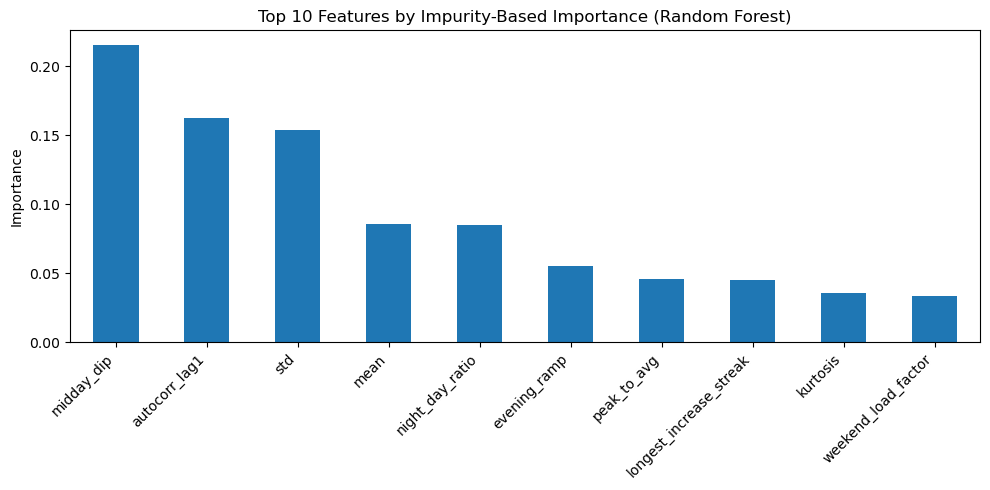

In [17]:
# Extract feature importances from the trained Random Forest
importances = pd.Series(
    random_forest_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10,5))
importances.head(10).plot(kind='bar')
plt.title("Top 10 Features by Impurity-Based Importance (Random Forest)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 9.2 Permutation-Based Feature Importance

Permutation importance measures how **prediction performance changes** when a feature's values are randomly shuffled. It reflects how much the model actually relies on each feature to make accurate predictions.

> **Advantage:** Model-agnostic and unbiased

> **Disadvantage**: Slower - requires re-evaluating the model multiple times

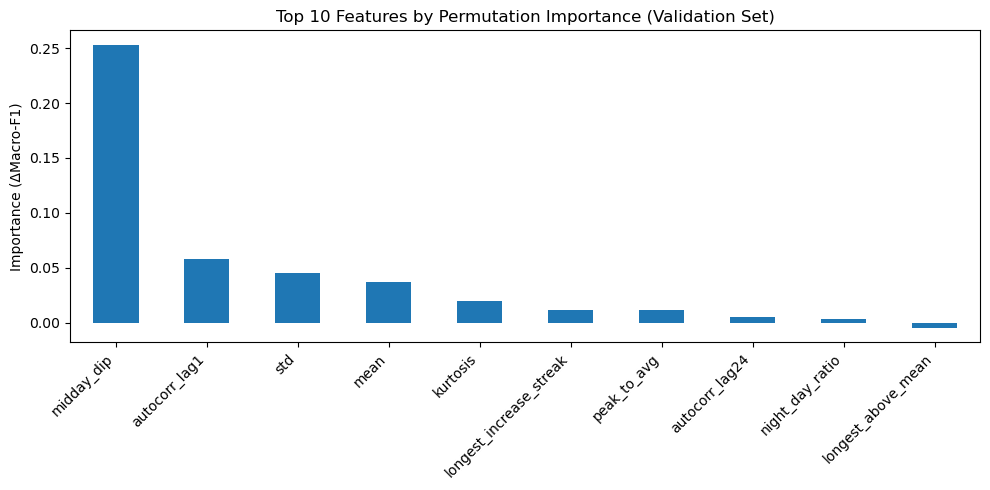

In [18]:
# Compute permutation importances using validation set
perm = permutation_importance(
    random_forest_model, X_val, y_val,
    n_repeats=10,
    random_state=random_seed
)

# Build importance series
perm_importances = pd.Series(
    perm.importances_mean,
    index=X_val.columns
).sort_values(ascending=False)

# Plot top 10 permutation importances
plt.figure(figsize=(10,5))
perm_importances.head(10).plot(kind='bar')
plt.title("Top 10 Features by Permutation Importance (Validation Set)")
plt.ylabel("Importance (ΔMacro-F1)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 9.3 Compare and Reflect

* Do the top features differ between the two methods?
* Are any **domain-informed features** (e.g., `midday_dip`, `evening_ramp`) ranked highly?
* Could you remove the least important features to simplify the model?

This kind of analysis can help prioritize sensor measurements, improve feature selection, and explain model behavior to stakeholders or regulators.

---

## 10. Interpreting the Best Decision Tree

This chapter focuses on **interpreting the internal logic of the most accurate individual decision tree** in the trained Random Forest. While Random Forests are powerful ensemble models, they can be difficult to explain directly due to the large number of trees involved. However, a single well-performing tree can reveal valuable, human-readable rules that describe how the model distinguishes DER types based on load features.

We will:

* Identify the most accurate tree in the forest using validation accuracy.
* Visualize its top-level structure.
* Extract and print all its decision rules in human-readable form.
* Analyze the conditions and thresholds used to make predictions.

These rules allow us to explain the model's behavior and build intuition about which features influence classification decisions.

Best Tree Index: 65, Validation Accuracy: 0.8667


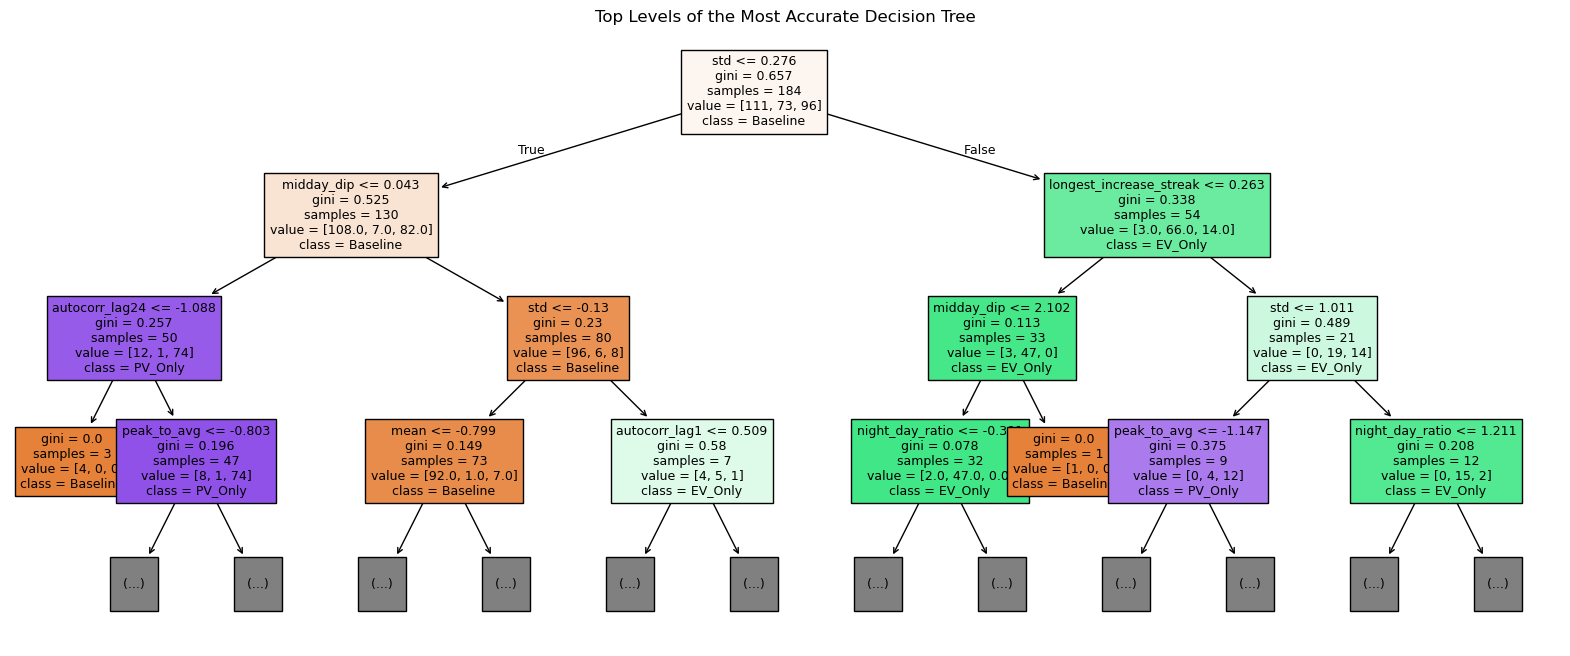

Rule 1: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 ≤ -1.09) THEN predict 'Baseline'
Rule 2: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 > -1.09) AND (peak_to_avg ≤ -0.80) THEN predict 'Baseline'
Rule 3: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 > -1.09) AND (peak_to_avg > -0.80) AND (midday_dip ≤ -0.03) AND (peak_to_avg ≤ -0.66) AND (evening_ramp ≤ 0.54) THEN predict 'PV_Only'
Rule 4: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 > -1.09) AND (peak_to_avg > -0.80) AND (midday_dip ≤ -0.03) AND (peak_to_avg ≤ -0.66) AND (evening_ramp > 0.54) THEN predict 'EV_Only'
Rule 5: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 > -1.09) AND (peak_to_avg > -0.80) AND (midday_dip ≤ -0.03) AND (peak_to_avg > -0.66) THEN predict 'PV_Only'
Rule 6: IF (std ≤ 0.28) AND (midday_dip ≤ 0.04) AND (autocorr_lag24 > -1.09) AND (peak_to_avg > -0.80) AND (midday_dip > -0.03) AND (weekend_load_factor ≤ -1.13) THEN predict 'Baseline'
Rul

In [19]:
from sklearn.tree import _tree, plot_tree # Visualize decision trees

# 1. Identify the best tree
X_val_np = X_val.to_numpy()  # Convert once before the loop

tree_accuracies = []
for idx, tree in enumerate(random_forest_model.estimators_):
    y_pred = tree.predict(X_val_np)
    y_pred = y_pred.astype(int)
    y_pred_labels = random_forest_model.classes_[y_pred]
    acc = accuracy_score(y_val, y_pred_labels)
    tree_accuracies.append((idx, acc))

best_idx, best_acc = max(tree_accuracies, key=lambda x: x[1])
best_tree = random_forest_model.estimators_[best_idx]
print(f"Best Tree Index: {best_idx}, Validation Accuracy: {best_acc:.4f}")


# 2. Visualize top 3 levels
plt.figure(figsize=(20, 8))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=random_forest_model.classes_,
    filled=True,
    max_depth=3,
    fontsize=9
)
plt.title("Top Levels of the Most Accurate Decision Tree")
plt.show()

# 3. Rule extraction
def extract_rules(tree, feature_names, class_names):
    rules = []
    def recurse(node, conditions):
        if tree.tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree.tree_.feature[node]]
            threshold = tree.tree_.threshold[node]
            recurse(tree.tree_.children_left[node], conditions + [f"({name} ≤ {threshold:.2f})"])
            recurse(tree.tree_.children_right[node], conditions + [f"({name} > {threshold:.2f})"])
        else:
            class_id = tree.tree_.value[node][0].argmax()
            rules.append((" AND ".join(conditions), class_names[class_id]))
    recurse(0, [])
    return rules

rules = extract_rules(best_tree, X_train.columns.tolist(), random_forest_model.classes_)

# 4. Print example rules
for i, (conds, pred) in enumerate(rules[:8]):
    print(f"Rule {i+1}: IF {conds} THEN predict '{pred}'")

> Choose one rule and explain in your own words:
>
> * What pattern of load behavior is this rule capturing?
> * How does it relate to PV or EV usage?
> * Is the rule simple enough to be trusted by a domain expert?

## 11. Summary and Conclusions

This notebook guided you through a full **supervised classification pipeline** using household smart meter features to detect the presence and type of distributed energy resources (DERs), such as photovoltaic systems (PV) or electric vehicles (EV).

Building on the unsupervised clustering work from Lecture 10, you learned how to train, evaluate, and interpret classifiers that operate on extracted load features. Throughout, the focus remained on building interpretable models and understanding the real-world meaning of model predictions.

---

### Concepts and Skills Covered

1. **Labeled Data Preparation**

   * Merged feature matrix with DER labels (None, PV, EV).
   * Performed stratified splitting into training, validation, and test sets.

2. **Baseline and Tree-Based Models**

   * Trained a Logistic Regression model as a performance baseline.
   * Implemented and evaluated Random Forest and LightGBM classifiers.
   * Used a validation set for early stopping and hyperparameter tuning.

3. **Performance Evaluation**

   * Compared models using:

     * Accuracy
     * Macro-averaged F1 score
     * Confusion matrices
     * Classification reports (precision, recall, support)
   * Interpreted what these metrics mean in the context of class imbalance.

4. **Model Interpretability**

   * Visualized and ranked feature importances using impurity-based and permutation methods.
   * Identified the most accurate decision tree from the Random Forest.
   * Extracted and interpreted human-readable decision rules.


---

### What You Have Learned

* How to construct a supervised classification pipeline for DER detection.
* Why and how to partition data into training, validation, and test sets with stratification.
* How to use multiple evaluation metrics to assess model quality, particularly under imbalance.
* How to extract interpretable logic from complex models.
* How feature importance analysis can inform both trust and feature design.

---

### Next Steps

To deepen your understanding and prepare for more advanced modeling tasks, consider the following directions:

1. **Hyperparameter Tuning**

   * Use `GridSearchCV` or `RandomizedSearchCV` to optimize model parameters.
   * Explore effects of tuning tree depth, learning rates, and class weights.

2. **Model Robustness and Fairness**

   * Analyze performance variability across time (e.g., seasonal effects).
   * Investigate fairness metrics—e.g., are DERs in rural vs. urban areas classified equally?

3. **Explainability**

   * Apply model-agnostic methods such as SHAP or LIME for instance-level explanations.
   * Compare global (e.g., feature importance) and local explanations (e.g., decision paths).

4. **Additional Feature Design**

   * Engineer temporal features, injection signatures, appliance-specific events.
   * Incorporate contextual data (e.g., weather, tariffs, building metadata).

---

This notebook provides a foundation for **interpretable, high-impact machine learning in energy systems**, enabling intelligent grid planning, DER monitoring, and consumer insight generation from smart meter data.
